<a href="https://colab.research.google.com/github/sirivandermeijden/TM10007_PROJECT_SvdMeijden_MMolenaar/blob/master/Assignment_vdMeijden_Molenaar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment 
# Mitchel Molenaar & Siri van der Meijden 


In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/sirivandermeijden/TM10007_PROJECT_SvdMeijden_MMolenaar     

In this script, head and neck cancer stages are predicted using three types of Machine Learning algorithms based on CT features. 

In [0]:
######## Import packages and models ##########################################

# Import general packages
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from sklearn import model_selection
from scipy.stats import randint

# import classifiers
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#import regularization
from sklearn.linear_model import LinearRegression, Ridge, Lasso 

# import models
models = [
    ('NB', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('LR', LogisticRegression()),
    ('SGD', SGDClassifier()),
    ('DT', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),   #hieronder verdere modellen toevoegen
]

# Import datapreprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import feature_selection 
from sklearn import decomposition
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals import joblib
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC


# Import split data in train and test set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # allows one scoring metric
from sklearn.model_selection import cross_validate # allows us to use multiple scoring metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold


# Import metrics
import statistics
from statistics import mean 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Import visualizers
import matplotlib.pyplot as plt
import seaborn as sns

# Learning curves
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit




In [0]:
######################### Data loading ##############################
from hn.load_data import load_data
data = load_data()
data.info

######################### Data exploration ###########################
# Print shape of dataset
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')

# Print class distribution
print('The class distributions are:')
print(data.groupby('label').size())
# From these outcomes we conclude the dataset is balanced in terms of labels

########################## Data preparation ##########################
# Map T12 and T34 to 0 and 1 respectively
mapping = {'T12': 0, 'T34': 1}
data=data.replace({'label': mapping})
# Select data with label
y= data['label']
# select data without label
X = data.drop(['label'], axis=1)
# delete duplicated columns if available
data = data.loc[:,~data.columns.duplicated()] 

# Makes from ID an index (0,1,2,3 etc.)
X.reset_index(drop=True, inplace=True)

# Splitting data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) # split train and test so that we don't touch test set. Split stratified with 'stratify'. Random=state is number so that outputs of runs are the same.

# Remove features with >40 missing values in training set and apply to test set.
threshold=40
to_remove = []
for col in X_train.columns:
    count_zeros = (X_train[col] == 0).sum()
    if  count_zeros > threshold:
        to_remove.append(col)
print('The amount of features removed with threshold in training set is %d.' % len(to_remove))
X_train = X_train.drop(to_remove, axis=1)
X_test = X_test.drop(to_remove, axis=1)

# Remove features with zero variance
X_train_var=X_train
selector = VarianceThreshold()
X_train=selector.fit_transform(X_train_var)
X_test=selector.transform(X_test)
total=len(to_remove)
print('The amount of features removed with zero variance in training set is %d.' % np.subtract(np.size(X_train_var,1), np.size(X_train,1)))
print('The total amount of features removed is %d.' % np.add(len(to_remove),np.subtract(np.size(X_train_var,1), np.size(X_train,1))))

# Replace zero values with 'nan' for future imputation 
X_train[X_train == 0] = 'nan'
X_test[X_test == 0] = 'nan'

# Imputation: used for test environment
imp = KNNImputer(n_neighbors=2, weights="uniform").fit(X_train)
X_train_imp=pd.DataFrame(imp.transform(X_train))
X_test_imp=pd.DataFrame(imp.transform(X_test))

## Scale: used for test environment
scaler = preprocessing.StandardScaler().fit(X_train_imp)
X_train_scale = scaler.transform(X_train_imp)
X_test_scale = scaler.transform(X_test_imp)


The number of samples: 113
The number of features: 160
The class distributions are:
label
T12    58
T34    55
dtype: int64
The amount of features removed with threshold in training set is 6.
The amount of features removed with zero variance in training set is 4.
The total amount of features removed is 10.


In [0]:
################ Model selection and hyperparameter tuning pipeline ###################

# This pipeline includes a randomized search for three different classifiers (KNN, RF and SVM), for which PCA or Lasso was used, resulting in six different randomized searches
# The pipeline includes KNN imputation of missing values, a standard scaler, a feature selection method (PCA/LASSO) and the classifier 

# Construct pipelines
n_comp_pca=27  # 90% of variance explained
pipe_knn_pca = Pipeline([('imp', KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
			('pca', PCA(n_components=n_comp_pca)),
      ('clf', KNeighborsClassifier())])

pipe_knn = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
      ('pca', PCA(n_components=n_comp_pca)),
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
      #('f_classif', SelectKBest(f_classif, k=2)),
      ('clf', KNeighborsClassifier())])

pipe_svm_pca = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
			('pca', PCA(n_components=n_comp_pca)),
			('clf', svm.SVC(random_state=42))])            #kernels aanpassen

pipe_svm = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
			('clf', svm.SVC(random_state=42))])     

pipe_rf_pca = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
			('pca', PCA(n_components=n_comp_pca)),
			('clf', RandomForestClassifier(random_state=42))])
    
pipe_rf = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
			('clf', RandomForestClassifier(random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_knn_pca, pipe_knn, pipe_svm_pca, pipe_svm, pipe_rf_pca, pipe_rf]
			
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'KNN', 1: 'Support Vector Machine', 1:'Random Forest'}

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

######### Hyperparameter ranges ##################################

# A range of 5-40 NN was chosen to be evaluated for the KNN algorithm to avoid under and overfitting  
grid_params_knn = [{'clf__n_neighbors': range(5,40)}]

# The parameters tuned for the SVM include the kernel and the slack parameter in a range of 1-10 
grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
                    'clf__C': param_range}]

# The parameters tuned for the RF include the splitting criterion, the number of trees 
# The maximum depth of the three and the minimum samples to split
grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
    'clf__n_estimators': range(10, 100, 10),						
    'clf__max_depth': param_range,
    'clf__min_samples_split': range(2,10)}]

# Construct grid searches, to perform parallel running 
jobs = -1

#Variables pipeline

# The scoring used for evalution of the models is the AUC 
score = 'roc_auc'
cross_val=10

# Altough not all three classifiers have 30 possible conformations of hyperparameters, this number was chosen since a relative high number of hyperparameters were tested for the RF
n_iteration=30

# Randomized searches for each of the classifiers 
gs_knn_pca = RandomizedSearchCV(estimator=pipe_knn_pca,			
			param_distributions=grid_params_knn,
			scoring=score,
			cv=cross_val,
      n_iter=n_iteration,
			n_jobs=jobs)

gs_knn = RandomizedSearchCV(estimator=pipe_knn,			
			param_distributions=grid_params_knn,
			scoring=score,
			cv=cross_val,
      n_iter=n_iteration,
			n_jobs=jobs)

gs_svm_pca = RandomizedSearchCV(estimator=pipe_svm_pca,			
			param_distributions=grid_params_svm,
			scoring=score,
			cv=cross_val,
      n_iter=n_iteration,
			n_jobs=jobs)

gs_svm = RandomizedSearchCV(estimator=pipe_svm,							
			param_distributions=grid_params_svm,
			scoring=score,
			cv=cross_val,
      n_iter=n_iteration,  
			n_jobs=jobs)

gs_rf = RandomizedSearchCV(estimator=pipe_rf,
			param_distributions=grid_params_rf,
			scoring=score,
			cv=cross_val,
      n_iter=n_iteration, 
			n_jobs=jobs)

gs_rf_pca = RandomizedSearchCV(estimator=pipe_rf_pca,
			param_distributions=grid_params_rf,
			scoring=score,
			cv=cross_val,
      n_iter=n_iteration, 
			n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_knn_pca, gs_knn, gs_svm_pca, gs_svm, gs_rf, gs_rf_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'KNN with pca', 1: 'KNN with lasso', 2: 'Support Vector Machine with pca', 3: 'Support Vector Machine with lasso', 4: 'Random forest with pca', 5:'Random forest with lasso'}

print('Performing model optimizations...')

# Make dataframe for evaluation of models 
df = pd.DataFrame({'Estimator': [], 'Best_params': [], 'Train_set_acc': [],'Val_set_acc': []})
df_b = pd.DataFrame({'Estimator': [], 'Best_params': [], 'Best_acc_train': [], 'Best_acc_val': []})
df_best_all = pd.DataFrame({'Estimator': [], 'Best_params': [], 'Best_acc_train': [], 'Best_acc_val': []})

best_auc_val = 0.0
best_clf = 0
best_gs = ''

# Split data in 5-fold stratified, to perform the randomized search five times over the test set 
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

# Perform randomized search for each of the models 
for train_index, val_index in skf.split(X_train, y_train):
  X_train_train, X_val = X_train[train_index], X_train[val_index]
  y_train_train, y_val = y_train[train_index], y_train[val_index]
  for idx, gs in enumerate(grids):
      # Fit randomized search	
      gs.fit(X_train_train, y_train_train)
      # Predict on test data with best params
      y_pred = gs.predict(X_val)
      # Test data accuracy of model with best params
      a_dictionary = {'Estimator':[grid_dict[idx]], 'Best_params':[gs.best_params_],'Train_set_acc':[gs.best_score_], 'Val_set_acc': [roc_auc_score(y_val, y_pred)]}
      dd=pd.DataFrame.from_dict(a_dictionary)
      df=pd.concat([df,dd], ignore_index=True)



Performing model optimizations...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

In [0]:
# Print dataframe with best hyperparameters for each of the models, ranked based on training AUC
df = df.sort_values(by=['Train_set_acc'], ascending=False)

# Print the 20 best performing estimators, from which a selection is made of 3 models with hyperparameters for which training AUC and validation AUC are equally performing 
df.head(20)



,Estimator,Best_params,Train_set_acc,Val_set_acc
26,Support Vector Machine with pca,"{'clf__kernel': 'rbf', 'clf__C': 6}",0.889583,0.812500
8,Support Vector Machine with pca,"{'clf__kernel': 'linear', 'clf__C': 1}",0.887500,0.611111
29,Random forest with lasso,"{'clf__n_estimators': 50, 'clf__min_samples_sp...",0.875000,0.762500
6,KNN with pca,{'clf__n_neighbors': 27},0.870833,0.555556
10,Random forest with pca,"{'clf__n_estimators': 30, 'clf__min_samples_sp...",0.864583,0.666667
5,Random forest with lasso,"{'clf__n_estimators': 60, 'clf__min_samples_sp...",0.864583,0.833333
2,Support Vector Machine with pca,"{'clf__kernel': 'linear', 'clf__C': 2}",0.856250,0.777778
20,Support Vector Machine with pca,"{'clf__kernel': 'rbf', 'clf__C': 2}",0.854167,0.666667
16,Random forest with pca,"{'clf__n_estimators': 30, 'clf__min_samples_sp...",0.854167,0.722222
14,Support Vector Machine with pca,"{'clf__kernel': 'rbf', 'clf__C': 7}",0.843750,0.611111


In [0]:
######## define chosen models ###########

# The models chosen to evaluate from the randomized search are as follows:

# Chosen RF classifier using Lasso generalization 
pipe_rf = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
			('clf', RandomForestClassifier(n_estimators = 80, criterion = 'gini', min_samples_split=4, max_depth=5, random_state=42))])

# Chosen SVM classifier with PCA 
pipe_svm_pca = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
			('pca', PCA(n_components=n_comp_pca)),
			('clf', svm.SVC(C=6, kernel = 'rbf', random_state=42))]) 

# Chosen KNN classifier with Lasso
pipe_knn = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
      ('pca', PCA(n_components=n_comp_pca)),
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
      ('clf', KNeighborsClassifier(n_neighbors=29))])

# Train and evaluate performance over whole trainingset using cross-validation 

models = {
    'Random forest': pipe_rf,
    'Support vector machine': pipe_svm_pca,
    'Knn': pipe_knn}

df = pd.DataFrame({'Estimator': [], 'Mean_AUC': [], 'Std_AUC': []})

# Perform cross validation on each of the three chosen models on the whole training set
for ind, key in enumerate(models):
  clf= models[key]
  AUC_CV = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
  a_dictionary = {'Estimator': [key], 'Mean_AUC': [mean(AUC_CV)], 'Std_AUC': [np.std(AUC_CV)]}
  dd=pd.DataFrame.from_dict(a_dictionary)
  df=pd.concat([df,dd], ignore_index=True)

df



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

,Estimator,Mean_AUC,Std_AUC
0,Random forest,0.8150,0.124599
1,Support vector machine,0.8750,0.116726
2,Knn,0.7925,0.126516


In [0]:
######## Chosen model evaluation ########
# In this part, the three final models are evaluated on the independent test set on different performance metrics 

models = {
    'Random forest': pipe_rf,
    'Support vector machine': pipe_svm_pca,
    'knn': pipe_knn}

df_scores = pd.DataFrame({'Estimator': [], 'roc_auc': [], 'accuracy': [],'f1_macro': [], 'precision_macro': [], 'recall_macro': []})

#
for ind, key in enumerate(models):
    clf = models[key]
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)  
    accuracy = clf.score(X_test, y_test)        # accuracy tested on test data without cross validation
    AUC = roc_auc_score(y_test, y_pred)
    a_dictionary = {'Estimator': [key], 'roc_auc': [AUC], 'accuracy': [accuracy_score(y_test, y_pred)],'f1_macro': [f1_score(y_test,y_pred)], 
                    'precision_macro': [precision_score(y_test,y_pred)], 'recall_macro': [recall_score(y_test,y_pred)]}
    dd=pd.DataFrame.from_dict(a_dictionary)
    df_scores=pd.concat([df_scores,dd], ignore_index=True)

df_scores


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Estimator,roc_auc,accuracy,f1_macro,precision_macro,recall_macro
0,Random forest,0.738636,0.739130,0.727273,0.727273,0.727273
1,Support vector machine,0.659091,0.652174,0.692308,0.600000,0.818182
2,knn,0.833333,0.826087,0.846154,0.733333,1.000000


Confusion matrix, without normalization
[[6 6]
 [2 9]]
Normalized confusion matrix (KNN)
[[0.5  0.5 ]
 [0.18 0.82]]


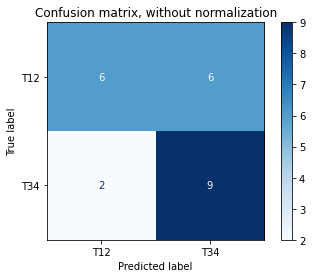

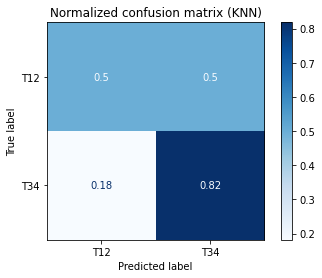

In [0]:
################# Confusion matrix ########################
# In this part, the confusion matrices are plotted for the classifiers 

pipe_svm_pca = Pipeline([('imp',KNNImputer(n_neighbors=2, weights="uniform")),
      ('scl', StandardScaler()),
			('pca', PCA(n_components=n_comp_pca)),
			('clf', svm.SVC(C=6, kernel = 'rbf', random_state=42, probability=True))]) 

clf = pipe_svm_pca
classifier = clf.fit(X_train, y_train)

np.set_printoptions(precision=2)

# define class labels 
class_names = ['T12', 'T34']

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix (KNN)", 'true')]

# Plot confusion matrix 
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

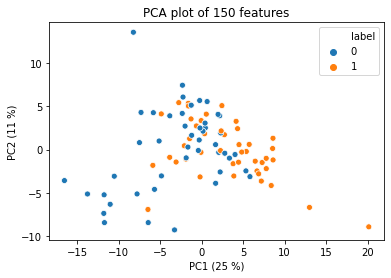

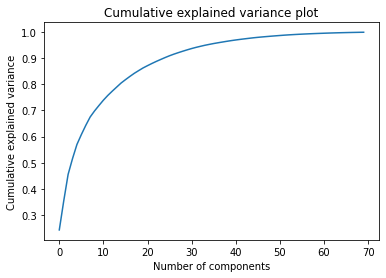

Recursive feature elimination: The highest accuraccy is achieved using the following 20 features: 
[0, 60, 87, 48, 81, 10, 54, 102, 121, 89, 101, 114, 109, 84, 3, 88, 112, 110, 26, 23]
Univariate feature seleciton: The highest accuraccy is achieved using the following 10 features: 
                                        Specs      Score
39           tf_GLRLM_LowGrayLevelRunEmphasis  40.738216
25                         sf_rad_dist_avg_2D  32.985190
32            tf_GLRLM_GrayLevelNonUniformity  32.420533
43                     tf_GLRLM_RunPercentage  30.933775
35          tf_GLRLM_HighGrayLevelRunEmphasis  30.378474
40                        tf_GLRLM_RunEntropy  30.287939
42  tf_GLRLM_RunLengthNonUniformityNormalized  30.278414
0                                   hf_energy  23.959068
41            tf_GLRLM_RunLengthNonUniformity  23.865741
36                   tf_GLRLM_LongRunEmphasis  23.487885
Shape of x_train after lasso feature selection:
(90, 68)
Feature ranking with forest of tr

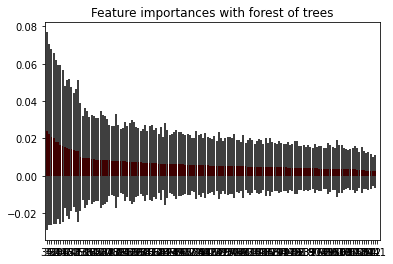

In [0]:
#### Test environment of feature selection methods ###
# In this part, different feature selection methods were tested and the results were used to get more insight in the data
# Due to the complexity of the data (seen in the PCA), 'simplified' feature extractions such as RFE and univariate feature selection were not used in the final model 

##########################Feature selection##########################################


########################### PCA ###################################################### 
pca = decomposition.PCA(n_components=70)       # 50 components explain >95 of variance. So 50 components is enough. 
pca_fit=pca.fit(X_train_scale)
X_train_pca = pca_fit.transform(X_train_scale)
X_test_pca = pca_fit.transform(X_test_scale)
explained_variance = pca_fit.explained_variance_ratio_

# Plot the first two PCA components, from this plot it can be seen that the data can not be seperated on its first two principal components 
plt.figure()
seaborn.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.xlabel("PC1 (25 %)")
plt.ylabel("PC2 (11 %)")
plt.title("PCA plot of 150 features")

# Explained variance
plt.figure()
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Cumulative explained variance plot")
plt.show()

###########################Recursive feature elimination (RFE)#######################

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")

# classifications using 5-fold stratified cross validation 
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(10),
    scoring='roc_auc')
rfecv.fit(X_train_scale, y_train)

n = 20 # to select top 13 features
feature_ranks = rfecv.ranking_  # selector is a RFECV fitted object
feature_ranks_with_idx = enumerate(feature_ranks)
sorted_ranks_with_idx = sorted(feature_ranks_with_idx, key=lambda x: x[1])
top_n_idx = [idx for idx, rnk in sorted_ranks_with_idx[:n]]
print("Recursive feature elimination: The highest accuraccy is achieved using the following 20 features: ")
print(top_n_idx)
#top_n_features = X_train_scale[:5, top_n_idx]
#print(top_n_features)

########################### Univariate feature selection ############################

# Using Anova-F (ANOVA F-value between label/feature for classification tasks.)
# apply SelectKBest class to extract top 20 best features

bestfeatures = SelectKBest(score_func=f_classif, k=20)
fit = bestfeatures.fit(X_train_scale,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
print("Univariate feature seleciton: The highest accuraccy is achieved using the following 10 features: ")
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

########################### Lasso feature selection ############################

# Using Anova-F (ANOVA F-value between label/feature for classification tasks.)
# apply SelectKBest class to extract top 20 best features

lsvc = LinearSVC(C=0.01, penalty="l2").fit(X_train_scale, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train_scale)
print('Shape of x_train after lasso feature selection:')
print(X_new.shape)


########################### Feature importance with forest of trees ##################

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train_scale, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking of the 20 most important features
print("Feature ranking with forest of trees:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances with forest of trees")
plt.bar(range(X_train_scale.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scale.shape[1]), indices)
plt.xlim([-1, X_train_scale.shape[1]])
plt.show()
